In [192]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as pltcolors
import numpy as np

from Bio import Entrez
from Bio import ExPASy
from Bio import SwissProt
Entrez.email = "user@gmail.com"

### Get SCAN domain location

In [193]:
def fetch_uniprot_record(uniprot_id):
    with ExPASy.get_sprot_raw(uniprot_id) as handle:
        return SwissProt.read(handle)

def get_domain_indices(uniprot_record):
    domain_indices = {}
    for feature in uniprot_record.features:
        if feature.type == 'DOMAIN':
            domain_indices[feature.qualifiers['note']] = [feature.location.start, feature.location.end]
    return domain_indices

In [194]:
target_protein_uniprot = fetch_uniprot_record('P28698')
domains = get_domain_indices(target_protein_uniprot)

start_scan, end_scan = domains['SCAN box']

### Load in datasets

In [195]:
cmut = pd.read_csv('../data/cancermuts_MZF1.csv')
alphamissense = pd.read_csv('../data/alphamissense/P28698/alphamissense_P28698.tsv', sep='\t')

In [196]:
# Select only scan domain residues from cancermuts dataset

# Select subset of cmut, which contains only mutations in the SCAN box
cmut_scan = cmut[(cmut['aa_position'] >= start_scan) & (cmut['aa_position'] <= end_scan)]

# Drop all rows with missing values in alt_aa
cmut_scan = cmut_scan.dropna(subset=['alt_aa'])

# Reset index
cmut_scan = cmut_scan.reset_index(drop=True)

# Count number of rows
n_mutations = cmut_scan.shape[0]

### Load in energies for P28698 mutatex alone

In [197]:
P28698_energies = pd.read_csv('../data/mutatex/all_energies/P28698_scand_energies.csv')

### Load in ddgs for proteins complexes with P28698

In [198]:
# P28698 complexes with itself has a bit different output in residue # column
P28698_complex_energies = pd.read_csv('../data/mutatex/all_energies/P28698_P28698_scand_complex_energies.csv')

# Convert Residue # to number preceeding '_' in Residue # column
P28698_complex_energies['Residue #'] = P28698_complex_energies['Residue #'].str.extract(r'(\d+)')

# Convert dtype from string to int in Residue #
P28698_complex_energies['Residue #'] = P28698_complex_energies['Residue #'].astype(int)

In [199]:
# Load in other complexes
O95125_complex_energies = pd.read_csv('../data/mutatex/all_energies/O95125_P28698_scand_complex_energies.csv')
P17028_complex_energies = pd.read_csv('../data/mutatex/all_energies/P17028_P28698_scand_complex_energies.csv')
P57086_complex_energies = pd.read_csv('../data/mutatex/all_energies/P57086_P28698_scand_complex_energies.csv')
Q15697_complex_energies = pd.read_csv('../data/mutatex/all_energies/Q15697_P28698_scand_complex_energies.csv')
Q8NBB4_complex_energies = pd.read_csv('../data/mutatex/all_energies/Q8NBB4_P28698_scand_complex_energies.csv')


# Add start_scan to Residue # to get canonical residue number of the P28698 protein scan domain
P28698_complex_energies['Residue #'] = P28698_complex_energies['Residue #'] + start_scan
O95125_complex_energies['Residue #'] = O95125_complex_energies['Residue #'] + start_scan
P17028_complex_energies['Residue #'] = P17028_complex_energies['Residue #'] + start_scan
P57086_complex_energies['Residue #'] = P57086_complex_energies['Residue #'] + start_scan
Q15697_complex_energies['Residue #'] = Q15697_complex_energies['Residue #'] + start_scan
Q8NBB4_complex_energies['Residue #'] = Q8NBB4_complex_energies['Residue #'] + start_scan



In [200]:
energies_df_dict = {'P28698': P28698_energies,
                    'P28698_complex': P28698_complex_energies,
                    'O95125_complex': O95125_complex_energies,
                    'P17028_complex': P17028_complex_energies,
                    'P57086_complex': P57086_complex_energies,
                    'Q15697_complex': Q15697_complex_energies,
                    'Q8NBB4_complex': Q8NBB4_complex_energies½}


SyntaxError: invalid character '½' (U+00BD) (3111153235.py, line 7)

### Create a collection dataframe of mutations present in cmut and their ddgs in all the dataframe in energies_df_dict

In [ ]:
cmut_mutations = []

# Get a list of mutation in cmut
for index, row in cmut_scan.iterrows():
    # Get the mutation
    mutation = row['ref_aa'] + str(row['aa_position']) + row['alt_aa']
    cmut_mutations.append(mutation)

# Create dataframe for the mutations
cmut_ddgs_df = pd.DataFrame(cmut_mutations, columns=['Mutation'])

# Left join alphamissense into cmut_ddgs_df
cmut_ddgs_df = cmut_ddgs_df.merge(alphamissense, how='left', left_on='Mutation', right_on='protein_variant')
cmut_ddgs_df = cmut_ddgs_df.drop(columns=['protein_variant', 'uniprot_id'])

# Loop over each protein structure and add ddgs for each mutation
for protein, energies_df in energies_df_dict.items():
    ddgs_protein = []
    for index, row in cmut_scan.iterrows():
        # Get the mutation
        ref_aa = row['ref_aa']
        mut_pos = row['aa_position']
        mut_aa = row['alt_aa']

        # Check if cmut mutation position is in the energies_df
        if mut_pos in energies_df['Residue #'].values:
            ddg_row = energies_df[energies_df['Residue #'] == mut_pos]
            
            # Get the ddg
            ddgs = float(ddg_row[mut_aa].values[0])
        else:
            ddgs = None
        
        ddgs_protein.append(ddgs)
        
    cmut_ddgs_df[protein] = ddgs_protein

# Set Mutation columns as indices
cmut_ddgs_df = cmut_ddgs_df.set_index('Mutation')
cmut_ddgs_df

,am_pathogenicity,am_class,P28698,O95125_complex,P17028_complex,P57086_complex,Q15697_complex,Q8NBB4_complex,P28698_complex
Mutation,,,,,,,,,
R44C,0.1503,benign,0.83912,NaN,NaN,NaN,NaN,NaN,NaN
R44H,0.1246,benign,1.80213,NaN,NaN,NaN,NaN,NaN,NaN
L45M,0.1707,benign,-0.07550,NaN,NaN,NaN,NaN,NaN,NaN
R46C,0.1186,benign,0.98232,-0.09436,NaN,NaN,NaN,-0.03966,-0.19550
R46H,0.1005,benign,0.86302,-0.05064,NaN,NaN,NaN,-0.06200,-0.13912
F47S,0.9650,pathogenic,2.79973,0.85252,0.62924,0.88926,1.01862,1.04646,2.30466
R48Q,0.1145,benign,0.77259,1.85362,0.29102,-0.95392,1.29436,0.36134,3.28590
R48W,0.1493,benign,0.51392,0.84176,-0.67036,-1.21282,1.28664,-0.74100,2.40962
R51H,0.0848,benign,0.67379,-0.09178,0.00292,-0.08164,-0.04558,0.09058,-0.03826


### Heatmapping cancermut

Text(904.4444444444445, 0.5, '')

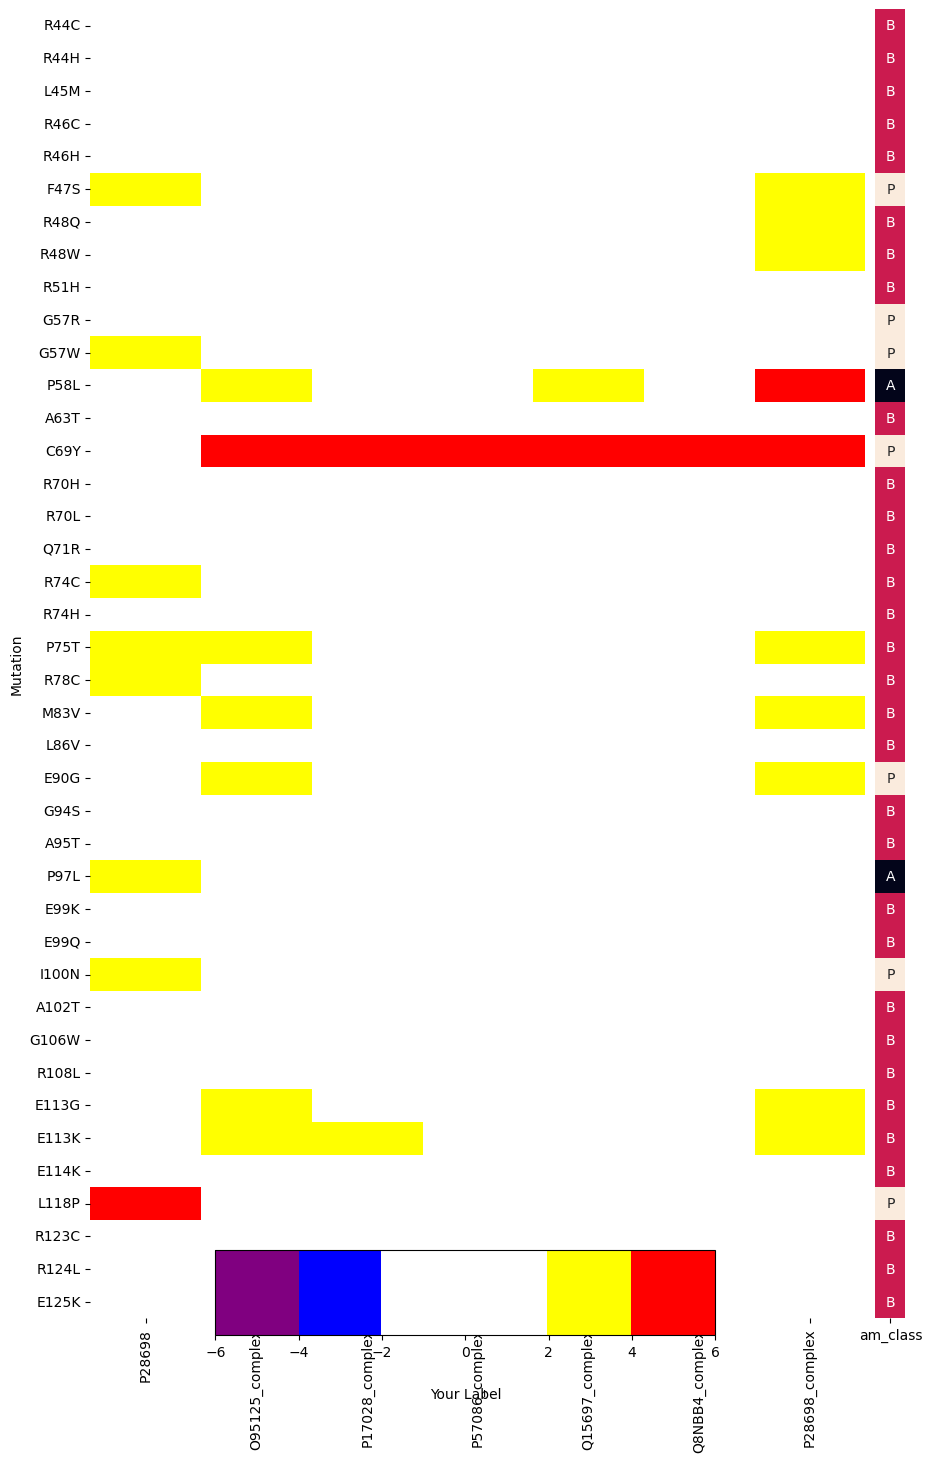

In [ ]:
# Get protein from cmut_ddgs_df
proteins = cmut_ddgs_df.columns[2:].values

# Create a mapping from categories to letters
mapping = {'benign': 'B', 'ambiguous': 'A', 'pathogenic': 'P'}

# Create a reverse mapping from letters to integer values
def reverse_map(x):
    reverse_map_dict = {'A': 0,
                        'B': 1,
                        'P': 2}
    for key, value in reverse_map_dict.items():
        if x == key:
            return value


# Apply the mapping to the 'pathogenicity_class' column
cmut_ddgs_df['am_class'] = cmut_ddgs_df['am_class'].map(mapping)

plt.figure(figsize=(10, 17))

#
#colors = ["purple", "blue", "white", "yellow", "red"]
#bounds = np.array([-np.inf, -5, -2, 2, 5, np.inf])

# Define custom color mapping
colors = sns.color_palette(["purple", "blue", "white", "white", "yellow", "red"])
thresholds = [-np.inf, -2, 0, 2, 5, np.inf]

ax1 = sns.heatmap(cmut_ddgs_df[proteins], cmap=colors, center=0, cbar=False, vmin=-6, vmax=6)

# Create a new axis for the colorbar at the bottom of the figure
cbar_ax = plt.gcf().add_axes([0.25, 0.1, 0.5, 0.05])

# Create the colorbar
cbar = plt.colorbar(ax1.collections[0], cax=cbar_ax, orientation='horizontal')

# Set the label for the colorbar
cbar.set_label('Your Label', rotation=0, labelpad=20)



# Create a new axis for the second heatmap
ax2 = plt.gcf().add_axes([.91, ax1.get_position().y0, .03, ax1.get_position().height])

# Create the second heatmap for the 'pathogenicity_class' column
sns.heatmap(cmut_ddgs_df['am_class'].apply(lambda x: reverse_map(x)).to_frame(), annot=cmut_ddgs_df[['am_class']], fmt='', cbar=False, yticklabels=False, ax=ax2)

# Remove y-axis label for the second heatmap
ax2.set_ylabel('')

# Distribution with or without cmut

#### Calculating the probability of being a stabilizing/destabilizing mutation in P28698

In [ ]:
# Get all amino acids that are stabilizing in the P28698 protein
mutation_columns = P28698_energies.columns[3:].values

# Each row, sum number of stabilizing mutations in mutation_columns
P28698_energies['n_stabilizing'] = P28698_energies[mutation_columns].apply(lambda x: x[x > 2].count(), axis=1)
P28698_energies['n_destabilizing'] = P28698_energies[mutation_columns].apply(lambda x: x[x < -2].count(), axis=1)

# Divide by the amount of mutations
n_mutations = P28698_energies.shape[0] * 20

# Sum n_stabilizing and divide by n_mutations
stabilization_rate = P28698_energies['n_stabilizing'].sum() / n_mutations
destabilization_rate = P28698_energies['n_destabilizing'].sum() / n_mutations
stabilization_rate, destabilization_rate


(0.2603658536585366, 0.001829268292682927)

In [ ]:
n_mutations_cmut = cmut_ddgs_df.shape[0]
n_stabilizing_cmut = (cmut_ddgs_df['P28698'] > 2).sum()
n_stabilizing_cmut / n_mutations_cmut

0.2

#### Calculating the probability of being a stabilizing mutation in complexes

In [ ]:
from scipy.stats import binom

for protein, energies_df in energies_df_dict.items():
    mutation_columns = energies_df.columns[3:].values
    energies_df['n_stabilizing'] = energies_df[mutation_columns].apply(lambda x: x[x > 2].count(), axis=1)
    energies_df['n_destabilizing'] = energies_df[mutation_columns].apply(lambda x: x[x < -2].count(), axis=1)
    
    n_mutations = energies_df.shape[0] * 20
    n_stabilizing = energies_df['n_stabilizing'].sum()
    n_destabilizing = energies_df['n_destabilizing'].sum()

    stabilization_rate = n_stabilizing / n_mutations
    destabilization_rate = n_destabilizing / n_mutations

    n_mutations_cmut = cmut_ddgs_df.shape[0]
    n_stabilizing_cmut = (cmut_ddgs_df[protein] > 2).sum()
    cmut_stabilization_rate =n_stabilizing_cmut / n_mutations_cmut

    # Calculate the probability of drawing at least n_stabilizing_cmut with a probability of stabilization_rate
    # aka. the probability of drawing the amount of stabilizing mutations we see in the cmut dataset, based on the probability of stabilizing mutations in the P28698 protein complex
    p = stabilization_rate
    n = n_mutations_cmut
    k = n_stabilizing_cmut
    p_of_drawing_n_stabilizing_cmut = 1 - (1- binom.cdf(k - 1, n, p))

    
    print(protein, round(stabilization_rate,4), round(cmut_stabilization_rate,4), round(p_of_drawing_n_stabilizing_cmut,4))

P28698 0.2604 0.2 0.1458
O95125_complex 0.1879 0.175 0.3541
P17028_complex 0.1637 0.025 0.0008
P57086_complex 0.1148 0.025 0.0076
Q15697_complex 0.143 0.05 0.016
Q8NBB4_complex 0.1385 0.025 0.0026
P28698_complex 0.2992 0.25 0.199


0.8009758928395357